<a href="https://www.kaggle.com/code/stutiiikatariaaa/gatedrecurrentunit?scriptVersionId=270017398" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping

2025-06-09 04:57:42.975992: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749445063.254697      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749445063.340027      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Load and process the dataset
df = pd.read_csv('/kaggle/input/solargeneration/dataset.csv')
df['date_time'] = pd.to_datetime(df['date_time'], format='%d-%m-%Y %H:%M')
df['hour'] = df['date_time'].dt.hour
df['day_of_week'] = df['date_time'].dt.dayofweek

# Select features and target
features = ['temperature', 'Ground_radiation_intensity ', 'hour']
X = df[features]
y = df['Photovoltaic_power_generation']

In [3]:
# Train-test split
train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape input to 3D for GRU: (samples, timesteps, features)
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [4]:
# Define GRU model
model = Sequential()
model.add(GRU(units=256, activation='tanh', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
model.fit(X_train_reshaped, y_train.values, epochs=100, batch_size=32,
          validation_split=0.2, verbose=1, callbacks=[early_stop])

2025-06-09 04:58:00.029337: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 3326215.0000 - val_loss: 2497884.2500
Epoch 2/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3220494.2500 - val_loss: 2399256.5000
Epoch 3/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3182613.0000 - val_loss: 2298136.7500
Epoch 4/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3016570.7500 - val_loss: 2211643.5000
Epoch 5/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2872794.2500 - val_loss: 2135780.0000
Epoch 6/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2806773.0000 - val_loss: 2067157.2500
Epoch 7/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2794070.2500 - val_loss: 2005052.8750
Epoch 8/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2611497.0000 - val_loss: 1947907.8750
Epoch 9/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2627312.5000 - val_loss: 1894229.7500
Epoch 10/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2596140.2500 - val_loss: 1840129.0000
Epoch 11

In [5]:
# Predict and evaluate
y_pred = model.predict(X_test_reshaped).flatten()
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print results
print("\nGRU Test Set Evaluation:")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

GRU Test Set Evaluation:
MSE: 372599.18
RMSE: 610.41
MAE: 402.90
R² Score: 0.7070


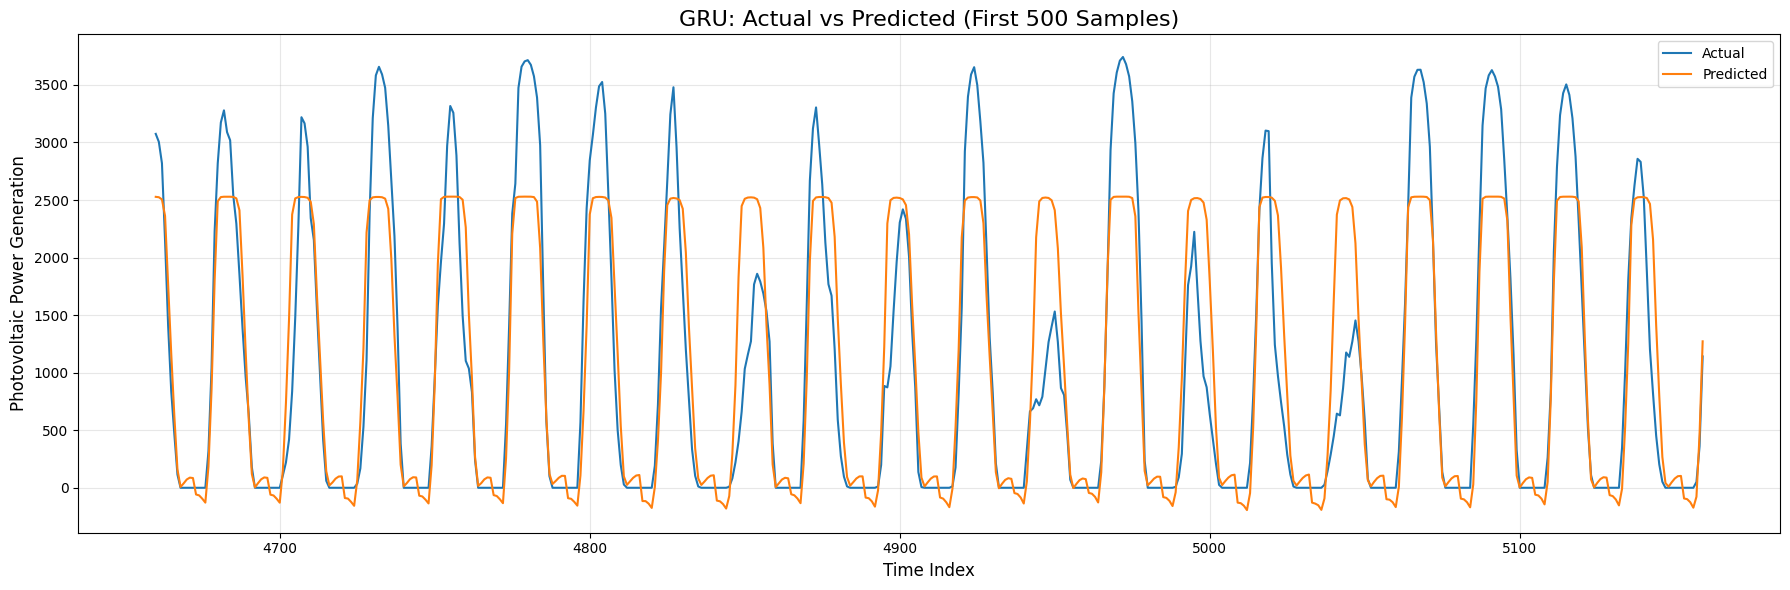

In [6]:
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=y_test.index)
plt.figure(figsize=(18, 6))
results.head(500).plot(ax=plt.gca())
plt.title("GRU: Actual vs Predicted (First 500 Samples)", fontsize=16)
plt.xlabel("Time Index", fontsize=12)
plt.ylabel("Photovoltaic Power Generation", fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [7]:
!pip install optuna

In [8]:
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Reshape data to 3D (if not already)
X_train_reshaped = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

# Optuna objective function
def objective(trial):
    units = trial.suggest_int('units', 32, 128)
    activation = trial.suggest_categorical('activation', ['tanh', 'relu'])
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])
    learning_rate = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    epochs = trial.suggest_int('epochs', 30, 100)

    if optimizer_name == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = RMSprop(learning_rate=learning_rate)

    # Build model
    model = Sequential()
    model.add(GRU(units=units, activation=activation, input_shape=(X_train_reshaped.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mse')

    # Train
    model.fit(X_train_reshaped, y_train, batch_size=batch_size, epochs=epochs, verbose=0)

    # Predict and evaluate
    y_pred = model.predict(X_test_reshaped)
    r2 = r2_score(y_test, y_pred)
    return r2  # Maximize R²


In [9]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25, timeout=1800)  # run for 25 trials or 30 mins

# Print best results
print("\nBest Trial:")
print(study.best_trial)


[I 2025-06-09 04:59:32,742] A new study created in memory with name: no-name-0df17247-71f7-4bad-aaf4-a2577212fcf7
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


[I 2025-06-09 04:59:57,930] Trial 0 finished with value: 0.8252577096137773 and parameters: {'units': 90, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.007142017223306225, 'batch_size': 64, 'epochs': 51}. Best is trial 0 with value: 0.8252577096137773.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


[I 2025-06-09 05:00:39,240] Trial 1 finished with value: 0.8204312447957682 and parameters: {'units': 66, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.00011679977971329724, 'batch_size': 32, 'epochs': 59}. Best is trial 0 with value: 0.8252577096137773.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


[I 2025-06-09 05:02:28,267] Trial 2 finished with value: 0.368585533381945 and parameters: {'units': 44, 'activation': 'tanh', 'optimizer': 'rmsprop', 'lr': 0.000911146575771069, 'batch_size': 16, 'epochs': 89}. Best is trial 0 with value: 0.8252577096137773.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


[I 2025-06-09 05:03:44,413] Trial 3 finished with value: 0.8180952944323269 and parameters: {'units': 123, 'activation': 'relu', 'optimizer': 'rmsprop', 'lr': 0.0005714266218856701, 'batch_size': 32, 'epochs': 87}. Best is trial 0 with value: 0.8252577096137773.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2025-06-09 05:05:06,819] Trial 4 finished with value: 0.820885774390285 and parameters: {'units': 84, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.007001154409896563, 'batch_size': 16, 'epochs': 67}. Best is trial 0 with value: 0.8252577096137773.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


[I 2025-06-09 05:06:26,773] Trial 5 finished with value: 0.582681545377674 and parameters: {'units': 96, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 0.0008635633085759082, 'batch_size': 16, 'epochs': 66}. Best is trial 0 with value: 0.8252577096137773.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


[I 2025-06-09 05:08:05,401] Trial 6 finished with value: 0.7609406895693529 and parameters: {'units': 89, 'activation': 'relu', 'optimizer': 'rmsprop', 'lr': 0.00903115244629416, 'batch_size': 16, 'epochs': 86}. Best is trial 0 with value: 0.8252577096137773.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2025-06-09 05:09:01,195] Trial 7 finished with value: 0.8183377593023888 and parameters: {'units': 57, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.0003845593341934633, 'batch_size': 16, 'epochs': 49}. Best is trial 0 with value: 0.8252577096137773.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2025-06-09 05:09:18,798] Trial 8 finished with value: -0.4562094636486529 and parameters: {'units': 89, 'activation': 'tanh', 'optimizer': 'rmsprop', 'lr': 0.0003576967508757089, 'batch_size': 64, 'epochs': 35}. Best is trial 0 with value: 0.8252577096137773.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2025-06-09 05:10:40,648] Trial 9 finished with value: 0.1323800322839751 and parameters: {'units': 123, 'activation': 'tanh', 'optimizer': 'rmsprop', 'lr': 0.00030060741731301183, 'batch_size': 16, 'epochs': 64}. Best is trial 0 with value: 0.8252577096137773.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2025-06-09 05:10:59,431] Trial 10 finished with value: 0.8246195546661594 and parameters: {'units': 111, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.002974026709563197, 'batch_size': 64, 'epochs': 32}. Best is trial 0 with value: 0.8252577096137773.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2025-06-09 05:11:17,887] Trial 11 finished with value: 0.8217814120844565 and parameters: {'units': 108, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.0030242022365778824, 'batch_size': 64, 'epochs': 32}. Best is trial 0 with value: 0.8252577096137773.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2025-06-09 05:11:41,093] Trial 12 finished with value: 0.8221112671492852 and parameters: {'units': 107, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.0028786084343653826, 'batch_size': 64, 'epochs': 45}. Best is trial 0 with value: 0.8252577096137773.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


[I 2025-06-09 05:12:07,352] Trial 13 finished with value: 0.824051537631739 and parameters: {'units': 106, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.003142230579078766, 'batch_size': 64, 'epochs': 47}. Best is trial 0 with value: 0.8252577096137773.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2025-06-09 05:12:25,322] Trial 14 finished with value: 0.826010461606518 and parameters: {'units': 75, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.004923948475737962, 'batch_size': 64, 'epochs': 40}. Best is trial 14 with value: 0.826010461606518.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


[I 2025-06-09 05:12:47,029] Trial 15 finished with value: 0.8267450708981923 and parameters: {'units': 70, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.005531736243625968, 'batch_size': 64, 'epochs': 53}. Best is trial 15 with value: 0.8267450708981923.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2025-06-09 05:13:05,313] Trial 16 finished with value: 0.8272149881803057 and parameters: {'units': 71, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.0015457102646662822, 'batch_size': 64, 'epochs': 40}. Best is trial 16 with value: 0.8272149881803057.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2025-06-09 05:13:32,919] Trial 17 finished with value: 0.8267718471176335 and parameters: {'units': 51, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.0015345768225248646, 'batch_size': 64, 'epochs': 75}. Best is trial 16 with value: 0.8272149881803057.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2025-06-09 05:14:18,364] Trial 18 finished with value: 0.05265729885382453 and parameters: {'units': 33, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 0.0015322968676973645, 'batch_size': 32, 'epochs': 78}. Best is trial 16 with value: 0.8272149881803057.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2025-06-09 05:14:55,318] Trial 19 finished with value: 0.8252561348827514 and parameters: {'units': 54, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.0013923059411084958, 'batch_size': 64, 'epochs': 97}. Best is trial 16 with value: 0.8272149881803057.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2025-06-09 05:15:24,222] Trial 20 finished with value: 0.821517686461676 and parameters: {'units': 60, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.0018074329430734567, 'batch_size': 64, 'epochs': 75}. Best is trial 16 with value: 0.8272149881803057.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2025-06-09 05:15:47,708] Trial 21 finished with value: 0.8235136976542253 and parameters: {'units': 73, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.0022078388015211183, 'batch_size': 64, 'epochs': 55}. Best is trial 16 with value: 0.8272149881803057.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2025-06-09 05:16:16,348] Trial 22 finished with value: 0.8280638752009782 and parameters: {'units': 46, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.004362340914878375, 'batch_size': 64, 'epochs': 74}. Best is trial 22 with value: 0.8280638752009782.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2025-06-09 05:16:44,619] Trial 23 finished with value: 0.8163338397953795 and parameters: {'units': 45, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.0011487652814132683, 'batch_size': 64, 'epochs': 77}. Best is trial 22 with value: 0.8280638752009782.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


[I 2025-06-09 05:17:13,282] Trial 24 finished with value: 0.8215858147650066 and parameters: {'units': 47, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.0006205776494491058, 'batch_size': 64, 'epochs': 72}. Best is trial 22 with value: 0.8280638752009782.



Best Trial:
FrozenTrial(number=22, state=1, values=[0.8280638752009782], datetime_start=datetime.datetime(2025, 6, 9, 5, 15, 47, 709388), datetime_complete=datetime.datetime(2025, 6, 9, 5, 16, 16, 347777), params={'units': 46, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.004362340914878375, 'batch_size': 64, 'epochs': 74}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'units': IntDistribution(high=128, log=False, low=32, step=1), 'activation': CategoricalDistribution(choices=('tanh', 'relu')), 'optimizer': CategoricalDistribution(choices=('adam', 'rmsprop')), 'lr': FloatDistribution(high=0.01, log=True, low=0.0001, step=None), 'batch_size': CategoricalDistribution(choices=(16, 32, 64)), 'epochs': IntDistribution(high=100, log=False, low=30, step=1)}, trial_id=22, value=None)


In [11]:
# Extract best params
best_params = study.best_params
print("\nBest Hyperparameters:", best_params)

# Build best model
if best_params['optimizer'] == 'adam':
    optimizer = Adam(learning_rate=best_params['lr'])
else:
    optimizer = RMSprop(learning_rate=best_params['lr'])

model = Sequential()
model.add(GRU(units=best_params['units'], activation=best_params['activation'],
              input_shape=(X_train_reshaped.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer=optimizer, loss='mse')

# Train best model
model.fit(X_train_reshaped, y_train,
          batch_size=best_params['batch_size'],
          epochs=best_params['epochs'], verbose=0)

# Predict
y_pred = model.predict(X_test_reshaped)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nOptuna-Tuned GRU Test Set Evaluation:")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}")



Best Hyperparameters: {'units': 46, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.004362340914878375, 'batch_size': 64, 'epochs': 74}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

Optuna-Tuned GRU Test Set Evaluation:
MSE: 238520.45
RMSE: 488.39
MAE: 302.31
R² Score: 0.8125


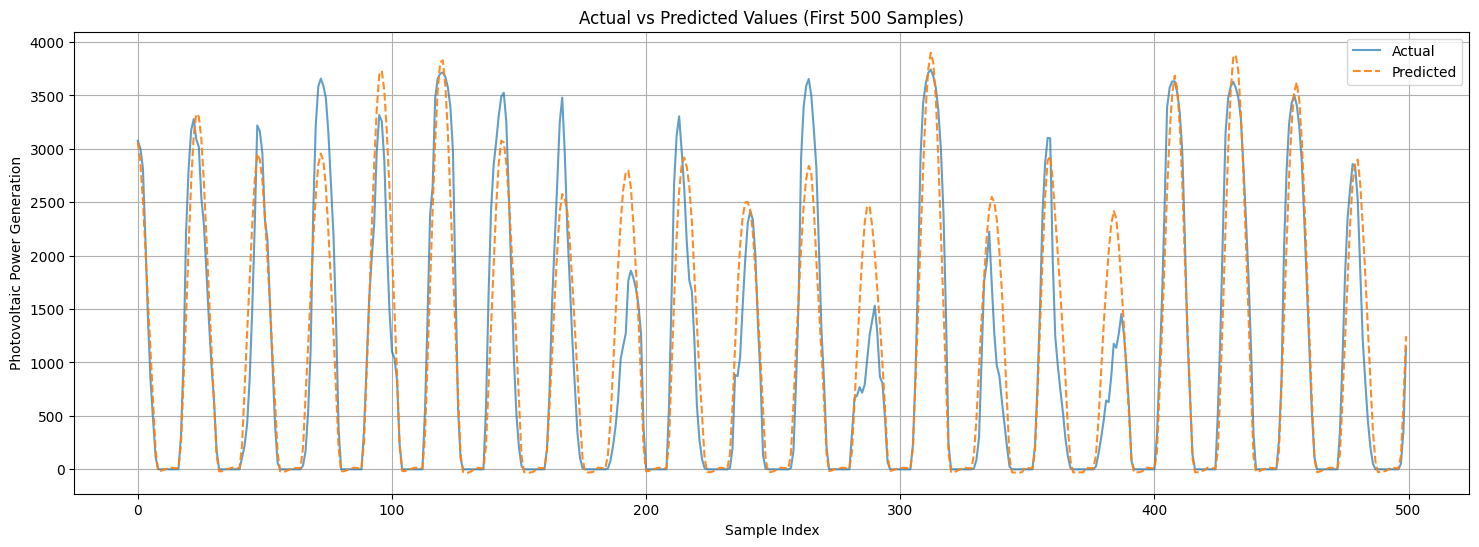

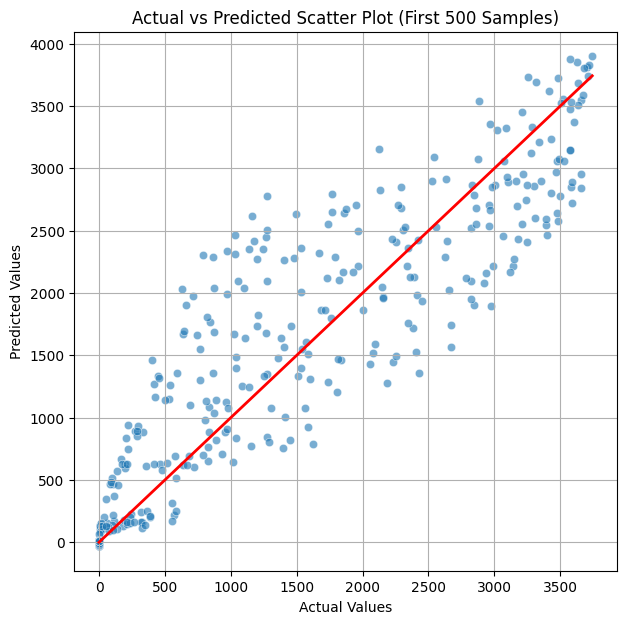

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# For the first 500 samples
y_test_500 = y_test[:500]
y_pred_500 = y_pred[:500].flatten()  # Ensure y_pred is 1D

# Line plot: Actual vs Predicted (time series style)
plt.figure(figsize=(18, 6))
plt.plot(y_test_500.values, label='Actual', alpha=0.7)
plt.plot(y_pred_500, label='Predicted', linestyle='--', alpha=0.9)
plt.title('Actual vs Predicted Values (First 500 Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Photovoltaic Power Generation')
plt.legend()
plt.grid(True)
plt.show()

# Scatter plot: Actual vs Predicted
plt.figure(figsize=(7, 7))
sns.scatterplot(x=y_test_500, y=y_pred_500, alpha=0.6)
plt.plot([y_test_500.min(), y_test_500.max()], [y_test_500.min(), y_test_500.max()], color='red', lw=2)
plt.title('Actual vs Predicted Scatter Plot (First 500 Samples)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()
